# INSTALACION DE LIBRERIAS

In [ ]:
!pip install cassandra-driver

# IMPORTACIÓN DE LIBRERIAS

In [ ]:
import json
from uuid import uuid4
from cassandra.cluster import Cluster
from cassandra.policies import RoundRobinPolicy
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

#CONEXION A CASSANDRA

In [ ]:

cassandra_host = 'raebl-190-11-239-205.a.free.pinggy.link'
keyspace = 'supplier'
try:
  cluster = Cluster(
    contact_points=[cassandra_host],
    port=32881,
    load_balancing_policy=RoundRobinPolicy(),
    protocol_version=5
  )
  session = cluster.connect()
  session.set_keyspace(keyspace)
  print("Successfully connected to Cassandra and keyspace 'supplier'!")
except Exception as e:
    print(f"Error connecting to Cassandra: {e}")


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/cassandra/cluster.py", line 3669, in _reconnect_internal
    return self._try_connect(host)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/cassandra/cluster.py", line 3691, in _try_connect
    connection = self._cluster.connection_factory(host.endpoint, is_control_connection=True)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/cassandra/cluster.py", line 1670, in connection_factory
    return self.connection_class.factory(endpoint, self.connect_timeout, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/cassandra/connection.py", line 857, in factory
    conn = cls(endpoint, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-pack

Successfully connected to Cassandra and keyspace 'supplier'!


FUNCION PARA INSERTAR EL ARCHIVO JSON A CASSANDRA

In [ ]:
def insert_json_file(
    session,
    json_file: str,
    insert_cql: str,
    required_fields=None,
    default_values=None,
    auto_id_field: str | None = None
):
    """
    Inserta en Cassandra usando INSERT ... JSON ? a partir de un archivo JSON.

    - session: sesión de Cassandra (session de cassandra-driver).
    - json_file: ruta del archivo JSON.
    - insert_cql: string del INSERT preparado, ej: "INSERT INTO products JSON ?".
    - required_fields: lista de campos que deben existir en el JSON.
    - default_values: dict con valores por defecto para campos faltantes o vacíos.
    - auto_id_field: nombre del campo al que se le generará un UUID si no viene.
    """

    required_fields = required_fields or []
    default_values = default_values or {}

    try:
        # 1. Leer archivo JSON
        with open(json_file, "r", encoding="utf-8") as f:
            data = json.load(f)

        # Si el archivo tiene un solo objeto, lo convertimos a lista
        if isinstance(data, dict):
            data = [data]

        # 2. Preparar el query del INSERT INTO
        insert_stmt = session.prepare(insert_cql)

        for obj in data:
            # 2.1 Auto-generar ID si aplica
            if auto_id_field:
                if auto_id_field not in obj or not obj.get(auto_id_field):
                    obj[auto_id_field] = str(uuid4())

            # 2.2 Validar / completar campos requeridos
            for field in required_fields:
                # si es el campo de ID auto-generado ya lo manejamos arriba
                if field == auto_id_field:
                    continue

                value = obj.get(field)

                # Si tenemos valor por defecto → lo usamos cuando falte o esté vacío
                if (value is None or value == "") and field in default_values:
                    obj[field] = default_values[field]

                # Si no hay default → lo consideramos error
                elif value is None:
                    raise ValueError(f"Falta el campo requerido: {field} en el objeto: {obj}")

            # 3. Insertar el objeto como JSON
            json_str = json.dumps(obj, ensure_ascii=False)
            session.execute(insert_stmt, [json_str])
            print("Insertado:", json_str)

        print(f"Todos los registros del archivo '{json_file}' fueron insertados correctamente")

    except Exception as e:
        print(f"Error al insertar desde '{json_file}': {e}")

CREAR TABLA DE PRODUCTOS

In [ ]:
try:
    print("Tabla de Products")
    session.execute(f"""
        CREATE TABLE IF NOT EXISTS {keyspace}.products (
            product_id uuid PRIMARY KEY,
            brands text,
            manufacturing_places text,
            product_name text,
            product_quantity double,
            product_quantity_unit text);
    """)
    print("Tabla de Products creada (o ya existía).")
except Exception as e:
    print(f"Error: {e}")


Tabla de Products
Tabla de Products creada (o ya existía).


INYECCION DE DATOS EN LA TABLA DE PRODUCTOS

In [ ]:

required_fields_products = [
    "product_id",
    "brands",
    "manufacturing_places",
    "product_name",
    "product_quantity",
    "product_quantity_unit"
]

default_values_products = {
    "brands": "SIN_MARCA",
    "manufacturing_places": "DESCONOCIDO",
    "product_name": "SIN_NOMBRE",
    "product_quantity": "0.00",
    "product_quantity_unit": "UN"
}

insert_json_file(
    session=session,
    json_file="products.json",
    insert_cql=f"INSERT INTO {keyspace}.products JSON ?",
    required_fields=required_fields_products,
    default_values=default_values_products,
    auto_id_field="product_id"
)

Insertado: {"product_id": "7a734d25-aca8-4567-b728-e910fbab7bd7", "brands": "maroc.", "manufacturing_places": "DESCONOCIDO", "product_name": "Sidi Ali", "product_quantity": 330, "product_quantity_unit": "ml"}
Insertado: {"product_id": "f91e73e8-b7c3-485e-a4f8-ea646e2fd12c", "brands": "perly", "manufacturing_places": "Maroc", "product_name": "perly", "product_quantity": 100, "product_quantity_unit": "g"}
Insertado: {"product_id": "ef1d70fb-ff10-42aa-ae6c-1c041210af5e", "brands": "sidi ali", "manufacturing_places": "DESCONOCIDO", "product_name": "Sidi Ali", "product_quantity": 2000, "product_quantity_unit": "ml"}
Insertado: {"product_id": "75e51f38-2045-40bf-914c-6f37196806f9", "brands": "Les Eaux Minérales d'oulmès,Sidi Ali", "manufacturing_places": "DESCONOCIDO", "product_name": "Eau minérale naturelle", "product_quantity": 1500, "product_quantity_unit": "ml"}
Insertado: {"product_id": "26d18ae5-0604-4a32-bc42-bfdd721da8bf", "brands": "AQUAFINA", "manufacturing_places": "Casablanca Mor

MOSTRAR LOS DATOS DE PRODUCTOS

In [ ]:
rows = session.execute(f"SELECT * FROM {keyspace}.products;")
for row in rows:
     print(row)

Row(product_id=UUID('63a6c69d-53c5-4d83-85d9-65670ea269ac'), brands='belvita', manufacturing_places='DESCONOCIDO', product_name='petit déjeuner miel et pépites de chocolat', product_quantity=435.0, product_quantity_unit='g')
Row(product_id=UUID('7f6845b2-36b5-48dd-af2c-ce7c186fd878'), brands='Danette', manufacturing_places='DESCONOCIDO', product_name='Danette chklat', product_quantity=0.0, product_quantity_unit='UN')
Row(product_id=UUID('05a9c520-d353-48a8-98b1-21362b8b1646'), brands="Jason's Sourdough", manufacturing_places='DESCONOCIDO', product_name='Proper Sourdough', product_quantity=450.0, product_quantity_unit='g')
Row(product_id=UUID('ba863d1d-7c3b-4469-9881-7130e6831c83'), brands='Gervais', manufacturing_places='DESCONOCIDO', product_name='Gervais', product_quantity=80.0, product_quantity_unit='g')
Row(product_id=UUID('79ced15f-6aa8-49a7-a2a6-4f119fe1d158'), brands='Azura', manufacturing_places='Dakhla,Sahara Occidental', product_name='Tomates cerises allongées', product_quant

CREAR TABLA DE LOT

In [ ]:
try:
  print("Tabla de Lot")
  session.execute(f"""
    CREATE TABLE IF NOT EXISTS {keyspace}.lot (
    lot_id text PRIMARY KEY,
    name text,
    production_date date);
  """)
  print("Tabla deLot creada (o ya existía).")
except Exception as e:
    print(f"Error: {e}")

Tabla de Lot
Tabla deLot creada (o ya existía).


INYECCION DE DATOS EN LA TABLA DE LOTES

In [ ]:
insert_json_file(
    session=session,
    json_file="batch.json",
    insert_cql=f"INSERT INTO {keyspace}.lot JSON ?",
    auto_id_field="lot_id"
)

Insertado: {"lot_id": "LOT001", "name": "Cristaline Water Batch A25", "production_date": "2025-01-18"}
Insertado: {"lot_id": "LOT002", "name": "Nutella Cream Lot 12B", "production_date": "2025-02-04"}
Insertado: {"lot_id": "LOT003", "name": "La Boulangère Brioche Lot F03", "production_date": "2025-02-22"}
Insertado: {"lot_id": "LOT004", "name": "Barilla Pesto Genovese Batch 07G", "production_date": "2025-03-01"}
Insertado: {"lot_id": "LOT005", "name": "Nestlé Dessert Chocolate Lot C15", "production_date": "2025-03-12"}
Insertado: {"lot_id": "LOT006", "name": "Danone Yogurt Natural Lot 05M", "production_date": "2025-03-27"}
Insertado: {"lot_id": "LOT007", "name": "Ethiquable Peanut Butter Lot 04E", "production_date": "2025-04-02"}
Insertado: {"lot_id": "LOT008", "name": "Menguy’s Salted Peanuts Lot 10F", "production_date": "2025-04-14"}
Insertado: {"lot_id": "LOT009", "name": "Jardin Bio Organic Spread Batch 03B", "production_date": "2025-04-30"}
Insertado: {"lot_id": "LOT010", "name": 

MOSTRAR LOS DATOS DE LOT

In [ ]:
rows = session.execute(f"SELECT * FROM {keyspace}.lot;")
for row in rows:
  print(row)

Row(lot_id='LOT005', name='Nestlé Dessert Chocolate Lot C15', production_date=Date(20159))
Row(lot_id='LOT011', name='Atlas Maghreb Mineral Water Lot 22M', production_date=Date(20226))
Row(lot_id='LOT001', name='Cristaline Water Batch A25', production_date=Date(20106))
Row(lot_id='LOT014', name='Kellogg’s Corn Flakes Lot CF09', production_date=Date(20259))
Row(lot_id='LOT009', name='Jardin Bio Organic Spread Batch 03B', production_date=Date(20208))
Row(lot_id='LOT010', name='Saint Hubert Margarine Lot V21', production_date=Date(20213))
Row(lot_id='LOT018', name='Bjorg Organic Muesli Batch B12', production_date=Date(20308))
Row(lot_id='LOT015', name='PepsiCo Hawai Tropical Lot H25', production_date=Date(20271))
Row(lot_id='LOT003', name='La Boulangère Brioche Lot F03', production_date=Date(20141))
Row(lot_id='LOT006', name='Danone Yogurt Natural Lot 05M', production_date=Date(20174))
Row(lot_id='LOT004', name='Barilla Pesto Genovese Batch 07G', production_date=Date(20148))
Row(lot_id='L

CREAR LA TABLA DE LOT_ITEM


In [ ]:
try:
  print("Tabla de Lot_Item")
  session.execute(f"""
    CREATE TABLE IF NOT EXISTS {keyspace}.lot_item (
    lot_id text,
    product_id uuid,
    product_name text,
    quantity double,
    PRIMARY KEY (lot_id, product_id)
  );
  """)
  print("Tabla de Lot_Item creada (o ya existía).")
except Exception as e:
    print(f"Error: {e}")

Tabla de Lot_Item
Tabla de Lot_Item creada (o ya existía).


INYECCION DE DATOS EN LA TABLA DE LOTES_ITEM

In [ ]:
insert_json_file(
    session=session,
    json_file="batch_item.json",
    insert_cql=f"INSERT INTO {keyspace}.lot_item JSON ?",
)

Insertado: {"lot_id": "LOT001", "product_id": "76f53234-8057-43aa-a0f2-7ec884b29635", "product_name": "Eau De Source", "quantity": 8200}
Insertado: {"lot_id": "LOT001", "product_id": "ef1d70fb-ff10-42aa-ae6c-1c041210af5e", "product_name": "Sidi Ali", "quantity": 5600}
Insertado: {"lot_id": "LOT002", "product_id": "3517bdd2-a6ed-4cbb-8514-36fedecc649d", "product_name": "Nutella", "quantity": 4800}
Insertado: {"lot_id": "LOT002", "product_id": "43f528ba-71f4-4808-9c50-884fce2dc325", "product_name": "Kinder Bueno", "quantity": 6900}
Insertado: {"lot_id": "LOT003", "product_id": "4f2cf8e4-3165-4da8-b1e3-11e84d9d5b72", "product_name": "Pain de Mie", "quantity": 3700}
Insertado: {"lot_id": "LOT004", "product_id": "12e30cda-8b94-49c9-8b2b-4252fc376d7a", "product_name": "PESTO alla GENOVESE", "quantity": 5900}
Insertado: {"lot_id": "LOT004", "product_id": "e54a8a9c-05d9-44a8-9f4b-473cf5e7cda9", "product_name": "Barilla Penne Rigate", "quantity": 7200}
Insertado: {"lot_id": "LOT005", "product_i

MOSTRAR LOS DATOS DE LA TABLA DE LOT_ITEM

In [ ]:
rows = session.execute(f"SELECT * FROM {keyspace}.lot_item;")
for row in rows:
  print(row)

Row(lot_id='LOT005', product_id=UUID('bdd9dbb7-dadc-4df6-9a5e-9c0c1e9e1a23'), product_name='Nestlé Dessert Chocolat Noir', quantity=5100.0)
Row(lot_id='LOT011', product_id=UUID('0c8126c8-9e74-4a42-bf38-9db0f4c9ad1d'), product_name='Bahia Eau Minérale', quantity=7700.0)
Row(lot_id='LOT001', product_id=UUID('76f53234-8057-43aa-a0f2-7ec884b29635'), product_name='Eau De Source', quantity=8200.0)
Row(lot_id='LOT001', product_id=UUID('ef1d70fb-ff10-42aa-ae6c-1c041210af5e'), product_name='Sidi Ali', quantity=5600.0)
Row(lot_id='LOT014', product_id=UUID('4f1baf2a-8ac9-47f0-8cb2-82ec47af61f7'), product_name="Kellogg's Extra Chocolat", quantity=5200.0)
Row(lot_id='LOT014', product_id=UUID('a0c03cb5-9a16-4cfb-9c35-740dc6d2b243'), product_name="Kellogg's Corn Flakes", quantity=8000.0)
Row(lot_id='LOT009', product_id=UUID('a19b5633-22e3-41df-b7db-64d967f80ab2'), product_name='Tartine Chocolat Bio', quantity=4100.0)
Row(lot_id='LOT010', product_id=UUID('43e3f786-bdfa-44dd-a612-b707f84d2b9a'), produc

CREAR LA TABLA DE SUPPLIERS

In [ ]:
try:
  print("Tabla de suppliers")
  session.execute(f"""
    CREATE TABLE IF NOT EXISTS {keyspace}.suppliers (
        supplier_id text PRIMARY KEY,
        name text,
        contact text,
        rating double,
        description text
    )
""")
  print("Tabla de suppliers creada (o ya existía).")
except Exception as e:
    print(f"Error: {e}")

Tabla de suppliers
Tabla de suppliers creada (o ya existía).


INYECCION DE DATOS EN LA TABLA DE SUPPLIERS

In [ ]:
insert_json_file(
    session=session,
    json_file="suppliers.json",
    insert_cql=f"INSERT INTO {keyspace}.suppliers JSON ?",
)

Insertado: {"supplier_id": "SUP001", "name": "Sources Alma Distribution", "contact": "contact@sourcesalma-distribution.com", "rating": 4.7, "description": "Distribuidor europeo de aguas minerales como Cristaline y Oulmès."}
Insertado: {"supplier_id": "SUP002", "name": "Ferrero France Commerciale", "contact": "ventas@ferrero-france-commerciale.com", "rating": 4.6, "description": "Distribuidor de confitería y cremas de cacao (Nutella, Kinder, Tic Tac)."}
Insertado: {"supplier_id": "SUP003", "name": "La Boulangère & Co Distribution", "contact": "comercial@laboulangere-co.com", "rating": 4.5, "description": "Panadería industrial francesa: panes, brioches y bollería."}
Insertado: {"supplier_id": "SUP004", "name": "Barilla & Wasa Logistics", "contact": "logistics@barilla-wasa.com", "rating": 4.4, "description": "Distribuidor de pasta italiana, pesto y productos Wasa crujientes."}
Insertado: {"supplier_id": "SUP005", "name": "Nestlé Waters Supply Europe", "contact": "orders@nestle-waters-supp

MOSTRAR LOS DATOS DE LA TABLA DE SUPPLIERS

In [ ]:
rows = session.execute(f"SELECT * FROM {keyspace}.suppliers;")
for row in rows:
  print(row)

Row(supplier_id='SUP014', contact='orders@premium-choco-biscuits.eu', description='Distribuye chocolates y galletas finas (Lindt, Milka, LU, BN, Poulain).', name='Premium Chocolates & Biscuits Europe', rating=4.3)
Row(supplier_id='SUP021', contact='contact@primevere-alternatives.fr', description='Margarinas vegetales y productos sin lactosa Primevère y Flora.', name='Primevère Dairy Alternatives', rating=4.1)
Row(supplier_id='SUP016', contact='info@pepsico-maghreb.com', description='Distribuye Aquafina, Pepsi, Quaker y Hawai Tropical.', name='PepsiCo North Africa Distribution', rating=4.5)
Row(supplier_id='SUP027', contact='contact@ainatlas.ma', description='Distribuye aguas minerales naturales Ain Atlas y Aïn Ifrane.', name='Aïn Atlas Waters', rating=4.4)
Row(supplier_id='SUP007', contact='clientes@danone-maghreb.com', description='Distribuidor regional de lácteos y aguas Danone (Ain Saïss, Jebli, Centrale).', name='Danone Maghreb & Dairy Services', rating=4.3)
Row(supplier_id='SUP020

CREAR LA TABLA DE TRANSPORT

In [ ]:
try:
  print("Tabla de transport")
  session.execute(f"""
    CREATE TABLE IF NOT EXISTS {keyspace}.transport (
        transport_id text PRIMARY KEY,
        supplier_id text,
        tag text,
        driver_name text,
        driver_contact text
    )
""")
  print("Tabla de transport creada (o ya existía).")
except Exception as e:
    print(f"Error: {e}")

Tabla de transport
Tabla de transport creada (o ya existía).


INYECCION DE DATOS EN LA TABLA DE TRANSPORT

In [ ]:
insert_json_file(
    session=session,
    json_file="transport.json",
    insert_cql=f"INSERT INTO {keyspace}.transport JSON ?",
)

Insertado: {"transport_id": "TRANS001", "supplier_id": "SUP001", "tag": "FR-4581-AA", "driver_name": "Louis Moreau", "driver_contact": "+33 6 82 14 7721"}
Insertado: {"transport_id": "TRANS002", "supplier_id": "SUP001", "tag": "FR-8732-BX", "driver_name": "Camille Roche", "driver_contact": "+33 6 77 12 3409"}
Insertado: {"transport_id": "TRANS003", "supplier_id": "SUP002", "tag": "FR-6742-ZB", "driver_name": "Antoine Lefèvre", "driver_contact": "+33 6 90 33 1487"}
Insertado: {"transport_id": "TRANS004", "supplier_id": "SUP002", "tag": "FR-3921-LM", "driver_name": "Lucien Dupont", "driver_contact": "+33 6 31 77 4559"}
Insertado: {"transport_id": "TRANS005", "supplier_id": "SUP003", "tag": "FR-9930-GR", "driver_name": "Claire Petit", "driver_contact": "+33 6 33 20 1140"}
Insertado: {"transport_id": "TRANS006", "supplier_id": "SUP004", "tag": "IT-2145-KM", "driver_name": "Marco Rossi", "driver_contact": "+39 342 556 1203"}
Insertado: {"transport_id": "TRANS007", "supplier_id": "SUP004", "

MOSTRAR LOS DATOS DE LA TABLA DE TRANSPORT

In [ ]:
rows = session.execute(f"SELECT * FROM {keyspace}.transport;")
for row in rows:
  print(row)

Row(transport_id='TRANS045', driver_contact='+212 6 50 21 7783', driver_name='Adil Mansouri', supplier_id='SUP017', tag='MA-7061-LQ')
Row(transport_id='TRANS007', driver_contact='+39 349 883 2210', driver_name='Giovanni De Luca', supplier_id='SUP004', tag='IT-7780-NP')
Row(transport_id='TRANS004', driver_contact='+33 6 31 77 4559', driver_name='Lucien Dupont', supplier_id='SUP002', tag='FR-3921-LM')
Row(transport_id='TRANS027', driver_contact='+212 6 72 88 2101', driver_name='Omar Harchi', supplier_id='SUP017', tag='MA-9855-PA')
Row(transport_id='TRANS050', driver_contact='+33 6 71 88 2234', driver_name='Marcel Thomas', supplier_id='SUP001', tag='FR-9500-LC')
Row(transport_id='TRANS009', driver_contact='+33 6 52 13 4987', driver_name='Pierre Durand', supplier_id='SUP005', tag='FR-8102-KL')
Row(transport_id='TRANS008', driver_contact='+33 6 71 95 4478', driver_name='Claire Dufour', supplier_id='SUP005', tag='FR-5591-CN')
Row(transport_id='TRANS012', driver_contact='+212 6 55 88 4411', d

CREAR LA TABLA DE LOT_TRACE

In [ ]:
try:
  print("Tabla de lot_trace")
  session.execute(f"""
    CREATE TABLE IF NOT EXISTS {keyspace}.lot_trace (
        lot_id text,
        event_id int,
        event_time timestamp,
        event_type text,
        origin_location text,
        destination_location text,
        supplier_id text,
        supplier_name text,
        transport_id text,
        transport_time int,
        transport_cost double,
        PRIMARY KEY (lot_id, event_id)
    )
""")
  print("Tabla de lot_trace creada (o ya existía).")
except Exception as e:
    print(f"Error: {e}")

Tabla de lot_trace
Tabla de lot_trace creada (o ya existía).


In [ ]:
insert_json_file(
    session=session,
    json_file="batch_trace.json",
    insert_cql=f"INSERT INTO {keyspace}.lot_trace JSON ?",
)

Insertado: {"event_id": 1, "lot_id": "LOT010", "event_time": "2020-05-23T01:43:00", "event_type": "Reprogramado", "origin_location": "Agadir, Marruecos", "destination_location": "Toulouse, Francia", "supplier_id": "SUP008", "supplier_name": "Ethiquable Fair Trade Foods", "transport_id": "TRANS027", "transport_time": 33, "transport_cost": 647.89}
Insertado: {"event_id": 2, "lot_id": "LOT002", "event_time": "2020-03-24T16:15:00", "event_type": "Reprogramado", "origin_location": "Casablanca, Marruecos", "destination_location": "Tánger, Marruecos", "supplier_id": "SUP019", "supplier_name": "Unilever Maghreb & Africa Foods", "transport_id": "TRANS028", "transport_time": 14, "transport_cost": 504.7}
Insertado: {"event_id": 3, "lot_id": "LOT018", "event_time": "2020-08-13T21:23:00", "event_type": "Entrega final", "origin_location": "Marseille, Francia", "destination_location": "Lyon, Francia", "supplier_id": "SUP030", "supplier_name": "Sultan North Africa Foods", "transport_id": "TRANS022", "

MOSTRAR LOS DATOS DE LA TABLA LOT_TRACE

In [ ]:
rows = session.execute(f"SELECT * FROM {keyspace}.lot_trace;")
for row in rows:
  print(row)

Row(lot_id='LOT005', event_id=7, destination_location='Oporto, Portugal', event_time=datetime.datetime(2020, 11, 7, 3, 34), event_type='Salida de planta', origin_location='Agadir, Marruecos', supplier_id='SUP030', supplier_name='Sultan North Africa Foods', transport_cost=749.46, transport_id='TRANS021', transport_time=32)
Row(lot_id='LOT014', event_id=9, destination_location='Nice, Francia', event_time=datetime.datetime(2020, 5, 26, 21, 26), event_type='Entrega final', origin_location='Rabat, Marruecos', supplier_id='SUP021', supplier_name='Primevère Dairy Alternatives', transport_cost=191.12, transport_id='TRANS050', transport_time=6)
Row(lot_id='LOT009', event_id=14, destination_location='Casablanca, Marruecos', event_time=datetime.datetime(2020, 7, 12, 8, 46), event_type='Reprogramado', origin_location='Hamburgo, Alemania', supplier_id='SUP013', supplier_name='Global Snacks & Chips Import', transport_cost=2432.27, transport_id='TRANS035', transport_time=65)
Row(lot_id='LOT010', even

In [ ]:
# Pequeño helper para pasar de CQL → DataFrame
def cql_to_df(query, params=None):
    rows = session.execute(query, params or {})
    return pd.DataFrame(list(rows))


## Gráfico: Top 10 proveedores con mejor rating

,supplier_id,name,rating
23,SUP001,Sources Alma Distribution,4.7
12,SUP025,Volvic & Evian Distribution,4.6
22,SUP005,Nestlé Waters Supply Europe,4.6
28,SUP017,Coca-Cola Export Company Morocco,4.6
9,SUP002,Ferrero France Commerciale,4.6
5,SUP020,Andros Fruit & Confiture Group,4.5
20,SUP006,Nestlé France Food & Drinks,4.5
2,SUP016,PepsiCo North Africa Distribution,4.5
19,SUP003,La Boulangère & Co Distribution,4.5
24,SUP023,Rigoni di Asiago Imports,4.5


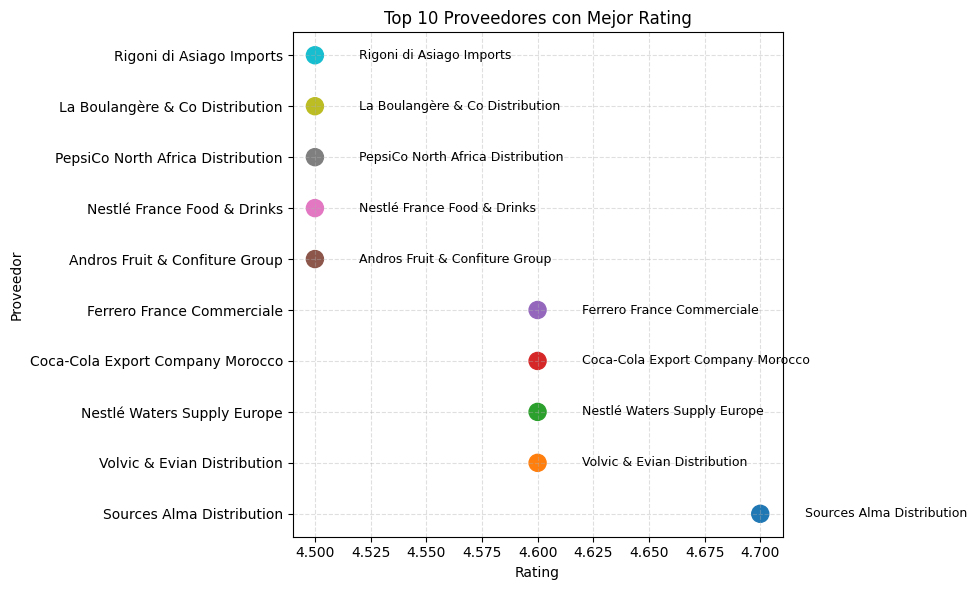

In [ ]:
suppliers_df = cql_to_df("""
    SELECT supplier_id, name, rating
    FROM suppliers
""")
top10 = suppliers_df.sort_values(by="rating", ascending=False).head(10)

display(top10)

num_suppliers = len(top10)
colors = plt.cm.tab10(np.linspace(0, 1, num_suppliers))

plt.figure(figsize=(10, 6))

plt.scatter(
    top10['rating'],
    top10['name'],
    c=colors,
    s=150
)

for i, row in top10.iterrows():
    plt.text(
        row['rating'] + 0.02,
        row['name'],
        row['name'],
        fontsize=9,
        va='center'
    )

plt.title("Top 10 Proveedores con Mejor Rating")
plt.xlabel("Rating")
plt.ylabel("Proveedor")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


**Análisis**

El proveedor "Sources Alma Distribution" es quien destaca claramente con un ranting alrededor de 4.70, el cual es el que se posiciona como el mayor entre los demás proveedores.

Esto se nos es útil al momento de elegir los proveedores de nuestros productos, ya que estos pueden destacar por sus tiempos o calidad. Los rating se encuentran entre 4.50 - 4.70, esto nos da a conocer que los proveedores de los prodcutos son de alta satisfacción.

## Gráfico: Volumen total por lote

,lot_id,product_id,product_name,quantity
0,LOT005,bdd9dbb7-dadc-4df6-9a5e-9c0c1e9e1a23,Nestlé Dessert Chocolat Noir,5100.0
1,LOT011,0c8126c8-9e74-4a42-bf38-9db0f4c9ad1d,Bahia Eau Minérale,7700.0
2,LOT001,76f53234-8057-43aa-a0f2-7ec884b29635,Eau De Source,8200.0
3,LOT001,ef1d70fb-ff10-42aa-ae6c-1c041210af5e,Sidi Ali,5600.0
4,LOT014,4f1baf2a-8ac9-47f0-8cb2-82ec47af61f7,Kellogg's Extra Chocolat,5200.0


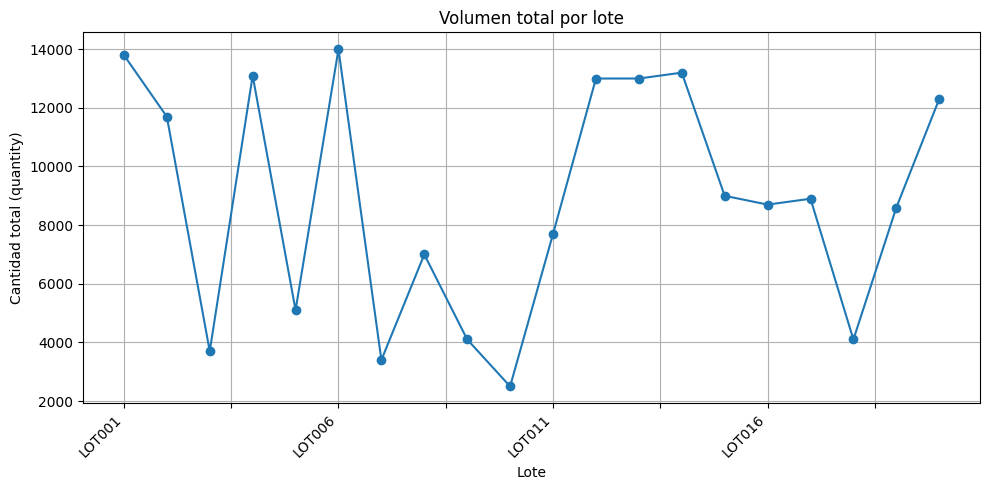

In [ ]:

lot_item_df = cql_to_df("""
    SELECT lot_id, product_id, product_name, quantity
    FROM lot_item
""")

display(lot_item_df.head())

volumen_por_lote = (
    lot_item_df
        .groupby("lot_id")["quantity"]
        .sum()
        .sort_index()
)
plt.figure(figsize=(10,5))

volumen_por_lote.plot(kind="line", marker="o")

plt.title("Volumen total por lote")
plt.xlabel("Lote")
plt.ylabel("Cantidad total (quantity)")
plt.xticks(rotation=45, ha='right')
plt.grid(True)

plt.tight_layout()
plt.show()


**Análisis**

El gráfico muestra el volumen total procesado por cada lote, utilizando un line plot donde cada punto representa un lote y su cantidad total.El primer patrón como es visible muestra una gran variabilidad, con picos altos que van desde 13,000 - 14,000, de igual forma muestra valles bajos como 2,000 - 3,000.

Podemos destacar de esta gráfica los picos de:

- LOT007/ LOT006(cerca de 14 000)
- LOT011(dos puntos alrededor de 13 000)
- LOT014(12 500 Aprox.)

Los valores más bajos aparecen en:

- LOT006 (punto cercano a 3 000)
- LOT011 (aprox. 4 000)
- Otros puntos intermedios alrededor de 5 000–6 000

## Gráfico: Distribución de eventos por tipos

,lot_id,event_id,event_time,event_type,origin_location,destination_location,supplier_id,supplier_name,transport_id,transport_time,transport_cost
0,LOT005,7,2020-11-07 03:34:00,Salida de planta,"Agadir, Marruecos","Oporto, Portugal",SUP030,Sultan North Africa Foods,TRANS021,32,749.46
1,LOT005,19,2020-10-28 18:13:00,Demora por inspección,"Fès, Marruecos","Marrakech, Marruecos",SUP011,Saint Hubert Plant-Based & Bio,TRANS047,21,363.82
2,LOT005,38,2020-11-01 18:35:00,Entrega final,"Casablanca, Marruecos","Londres, Reino Unido",SUP027,Aïn Atlas Waters,TRANS011,32,955.03
3,LOT005,44,2020-10-01 03:26:00,En tránsito,"Marseille, Francia","Toulouse, Francia",SUP008,Ethiquable Fair Trade Foods,TRANS021,17,678.36
4,LOT005,61,2020-11-14 04:48:00,Salida de planta,"Marseille, Francia","Zurich, Suiza",SUP026,Whole Earth Organic & Natural Foods,TRANS042,64,517.25


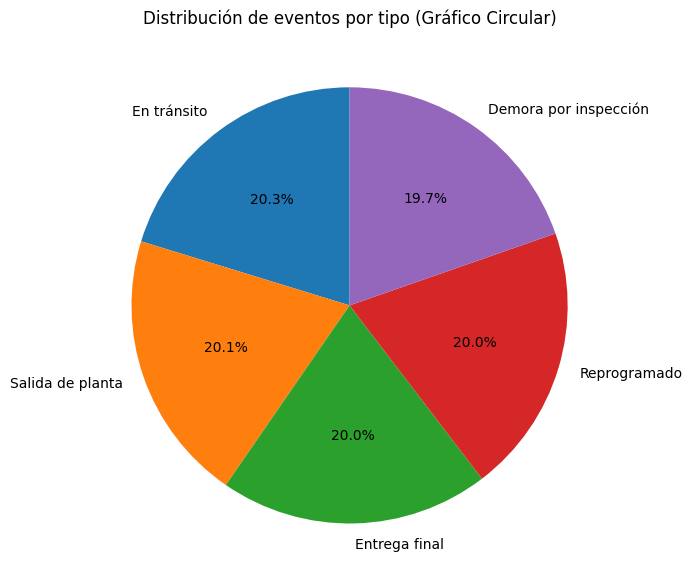

In [ ]:
lot_trace_df = cql_to_df("""
    SELECT lot_id,
           event_id,
           event_time,
           event_type,
           origin_location,
           destination_location,
           supplier_id,
           supplier_name,
           transport_id,
           transport_time,
           transport_cost
    FROM lot_trace
""")

display(lot_trace_df.head())

event_counts = lot_trace_df['event_type'].value_counts()

plt.figure(figsize=(7,7))
plt.pie(
    event_counts,
    labels=event_counts.index,
    autopct='%1.1f%%',
    startangle=90
)

plt.title("Distribución de eventos por tipo")
plt.tight_layout()
plt.show()


**Análisis**

El gráfico circular muestra la proporción de eventos operativos registrados para los distintos tipos de evento dentro de la trazabilidad logística. Cada segmento representa la frecuencia relativa de cada tipo.

Tipos de evento incluidos:
- Demora por inspección
- Reprogramado
- Entrega final
- Salida de planta
- En tránsito

Las proporciones están extremadamente parejas, oscilando entre 19.7% y 20.3%, lo cual indica que:

- No hay un tipo de evento que domine.
- Los procesos registran eventos de una manera balanceada.

## Gráfico: Top 5 proveedores más eficientes

/tmp/ipython-input-2419957522.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data, labels=proveedores_orden, patch_artist=True)


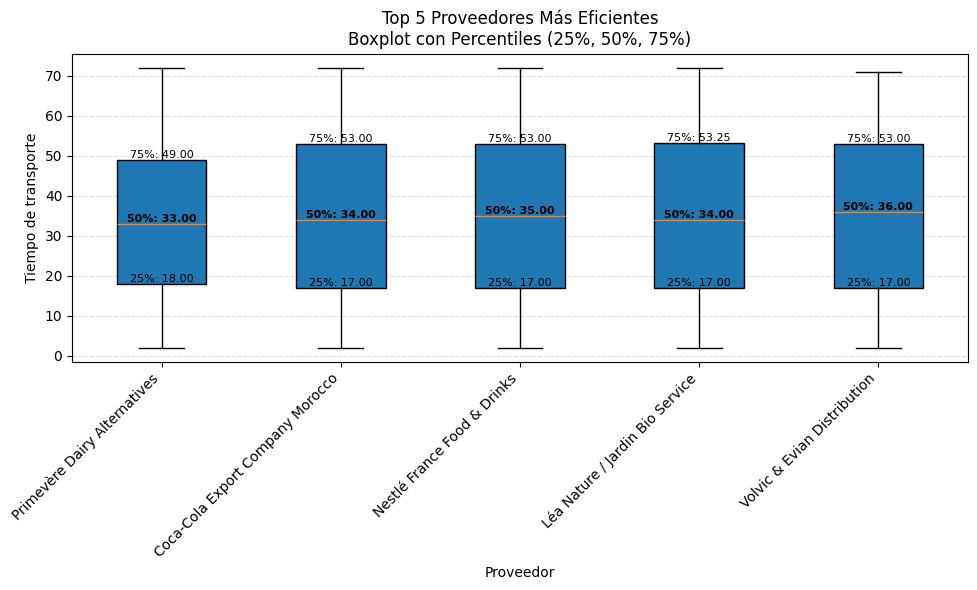

In [ ]:
df_time = lot_trace_df.dropna(subset=['transport_time'])

tiempo_promedio_proveedor = (
    df_time
        .groupby('supplier_name')['transport_time']
        .mean()
        .sort_values()
)

top5_proveedores = tiempo_promedio_proveedor.head(5)
df_top5 = df_time[df_time['supplier_name'].isin(top5_proveedores.index)]

proveedores_orden = list(top5_proveedores.index)

data = [df_top5[df_top5['supplier_name'] == proveedor]['transport_time'].values
        for proveedor in proveedores_orden]

plt.figure(figsize=(10,6))

bp = plt.boxplot(data, labels=proveedores_orden, patch_artist=True)

for i, proveedor in enumerate(proveedores_orden):
    valores = df_top5[df_top5['supplier_name'] == proveedor]['transport_time']

    q1 = np.percentile(valores, 25)
    q2 = np.percentile(valores, 50)
    q3 = np.percentile(valores, 75)

    plt.text(i + 1, q1, f"25%: {q1:.2f}", ha='center', va='bottom', fontsize=8)
    plt.text(i + 1, q2, f"50%: {q2:.2f}", ha='center', va='bottom', fontsize=8, fontweight='bold')
    plt.text(i + 1, q3, f"75%: {q3:.2f}", ha='center', va='bottom', fontsize=8)

plt.title("Top 5 Proveedores Más Eficientes\nBoxplot con Percentiles (25%, 50%, 75%)")
plt.xlabel("Proveedor")
plt.ylabel("Tiempo de transporte")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


**Análisis**

El gráfico muestra la distribución del tiempo de transporte por proveedor usando un boxplot, incluyendo percentiles clave:

- 25% (Q1)
- 50% (Mediana)
- 75% (Q3)

Esto permite comparar variabilidad, consistencia y eficiencia real de cada proveedor.
**Más consistente:**

- Coca-Cola Export Company Morocco

    * Mediana: 33.00
    * IQR: 53 – 17 = 36

- Proveedor con menor mediana absoluta:

    * Primavère Dairy Alternatives
    * Mediana: 33.00 (igual que Coca-Cola), pero Q1 más alto (18), lo que sugiere menos entregas ultra rápidas.

- Proveedor más rápido en promedio:

    * Volvic & Evian Distribution
    * Mediana más baja del grupo (36 → aunque ligeramente mayor, muestra uniformidad)
    * Q1 bajo (17) → tiene entregas rápidas frecuentes.

## Gráfico: Tiempo vs Costo

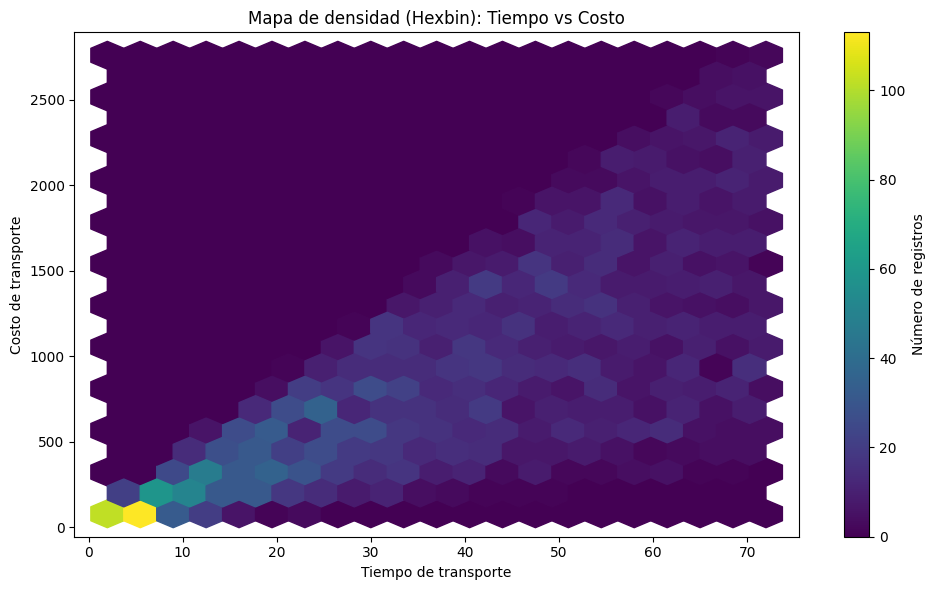

In [ ]:
plt.figure(figsize=(10,6))

plt.hexbin(
    df_tc['transport_time'],
    df_tc['transport_cost'],
    gridsize=20
)

plt.colorbar(label='Número de registros')
plt.title("Mapa de densidad : Tiempo vs Costo")
plt.xlabel("Tiempo de transporte")
plt.ylabel("Costo de transporte")
plt.tight_layout()
plt.show()


**Análisis**

Este gráfico representa la relación entre tiempo de transporte (eje X) y costo de transporte (eje Y), utilizando un hexbin para mostrar dónde se acumulan más registros.
Los colores indican densidad:
- Amarillo / Verde claro → muy alta concentración
- Verde / Azul → media
- Morado oscuro → baja o nula

El patrón general forma una diagonal ascendente, donde:
- Cuando el tiempo aumenta, el costo también tiende a aumentar.
- La nube de densidad se expande proporcionalmente.

La forma triangular sugiere que:
- Para tiempos bajos, hay una gran variabilidad en costo (0–300).
- Para tiempos altos (50–70h), los costos tienden a ser de 800+.

## Gráfico: Lotes y sus productos

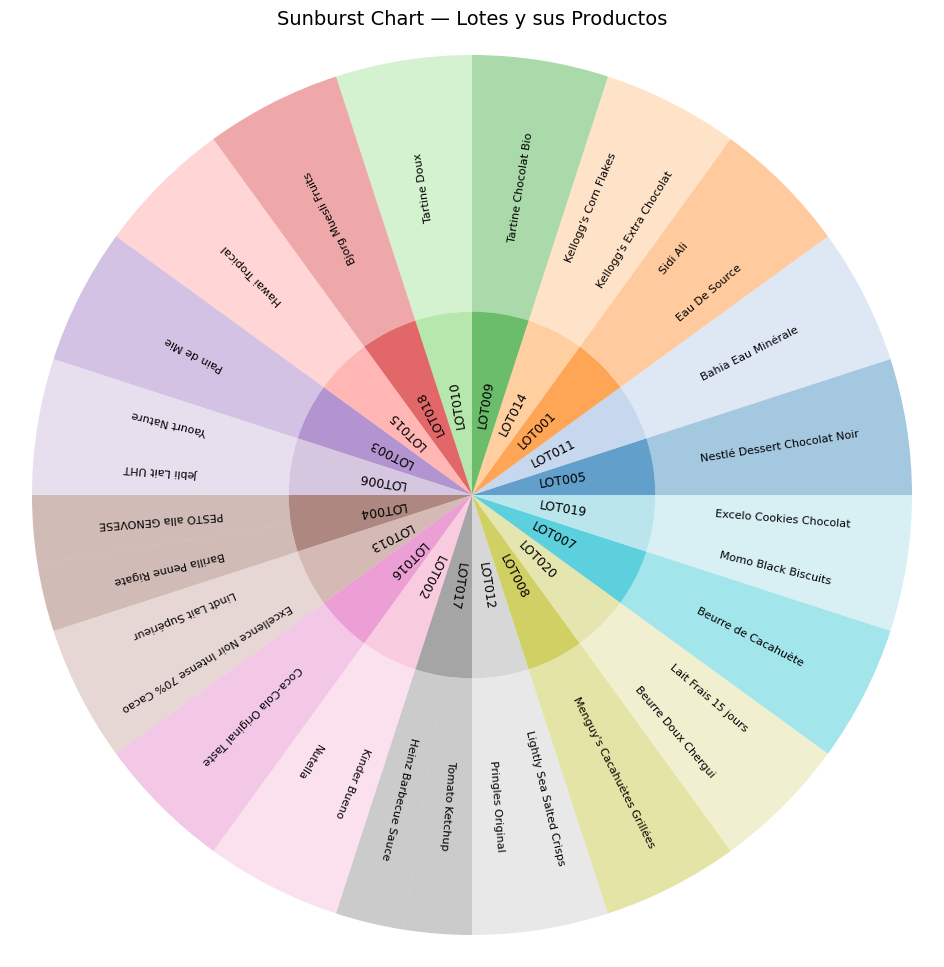

In [ ]:
lotes = lot_item_df['lot_id'].unique()

estructura = {
    lote: lot_item_df[lot_item_df['lot_id'] == lote]['product_name'].tolist()
    for lote in lotes
}

fig, ax = plt.subplots(figsize=(12,12), subplot_kw=dict(polar=True))

num_lotes = len(estructura)
theta = np.linspace(0, 2*np.pi, num_lotes+1)

colors = plt.cm.tab20(np.linspace(0, 1, num_lotes))

for i, (lote, productos) in enumerate(estructura.items()):
    ax.bar(
        x=(theta[i] + theta[i+1]) / 2,
        height=0.5,
        width=theta[i+1] - theta[i],
        bottom=0,
        color=colors[i],
        alpha=0.7
    )
    ax.text(
        x=(theta[i] + theta[i+1]) / 2,
        y=0.25,
        s=lote,
        ha='center',
        va='center',
        fontsize=9,
        rotation=np.degrees((theta[i] + theta[i+1]) / 2),
    )

    num_prod = len(productos)
    if num_prod > 0:
        theta_prod = np.linspace(theta[i], theta[i+1], num_prod+1)

        for j, prod in enumerate(productos):
            ax.bar(
                x=(theta_prod[j] + theta_prod[j+1]) / 2,
                height=0.7,
                width=theta_prod[j+1] - theta_prod[j],
                bottom=0.5,
                color=colors[i],
                alpha=0.4
            )

            ax.text(
                x=(theta_prod[j] + theta_prod[j+1]) / 2,
                y=0.85,
                s=prod,
                ha='center',
                va='center',
                fontsize=8,
                rotation=np.degrees((theta_prod[j] + theta_prod[j+1]) / 2),
            )

ax.set_axis_off()
plt.title("Lotes y sus Productos", fontsize=14)
plt.show()

**Análisis**

El gráfico Sunburst representa una relación jerárquica entre:

- Nivel 1 (centro): Lotes
- Nivel 2 (anillos exteriores): Productos asociados a cada lote

Este tipo de visualización es ideal para mostrar cómo están distribuidos los productos dentro de cada lote, y si ciertos lotes contienen más o menos variedad que otros.

Cada producto tiene un color distinto, lo que facilita:
- Identificar rápidamente qué producto pertenece a qué lote
- Evitar confusiones entre categorías